# Implementing a Recommender System with SageMaker, MXNet, and Gluon
## _**Making Product - Shoes Recommendations Using Neural Networks and Embeddings**_

--- 


## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
  1. [Explore](#Explore)
  1. [Clean](#Clean)
  1. [Prepare](#Prepare)
1. [Train Locally](#Train-Locally)
  1. [Define Network](#Define-Network)
  1. [Set Parameters](#Set-Parameters)
  1. [Execute](#Execute)
1. [Train with SageMaker](#Train-with-SageMaker)
  1. [Wrap Code](#Wrap-Code)
  1. [Move Data](#Move-Data)
  1. [Submit](#Submit)
1. [Host](#Host)
  1. [Evaluate](#Evaluate)
1. [Wrap-up](#Wrap-up)

---

## Background

#### In many ways, recommender systems were a catalyst for the current popularity of machine learning.  One of Amazon's earliest successes was the "Customers who bought this, also bought..." feature, while the million dollar Netflix Prize spurred research, raised public awareness, and inspired numerous other data science competitions.

#### Recommender systems can utilize a multitude of data sources and ML algorithms, and most combine various unsupervised, supervised, and reinforcement learning techniques into a holistic framework.  However, the core component is almost always a model which which predicts a user's rating (or purchase) for a certain item based on that user's historical ratings of similar items as well as the behavior of other similar users.  The minimal required dataset for this is a history of user item ratings.  In our case, we'll use 1 to 5 star ratings from over 2M Amazon customers.  More details on this dataset can be found at its [AWS Public Datasets page](https://s3.amazonaws.com/amazon-reviews-pds/readme.html).

#### Matrix factorization has been the cornerstone of most user-item prediction models.  This method starts with the large, sparse, user-item ratings in a single matrix, where users index the rows, and items index the columns.  It then seeks to find two lower-dimensional, dense matrices which, when multiplied together, preserve the information and relationships in the larger matrix.

![image](./images/1_PefuBiYr9Bp7lo_zotGj0Q.png)

### ** Matrix factorization has been extended and genarlized with deep learning and embeddings.  These techniques allows us to introduce non-linearities for enhanced performance and flexibility.  This notebook will fit a neural network-based model to generate recommendations for the Amazon dataset.  It will start by exploring our data in the notebook and even training a model on a sample of the data.  Later we'll expand to the full dataset and fit our model using a SageMaker managed training cluster.  We'll then deploy to an endpoint and check our method.

---

## Setup

#### _This notebook was created and tested on an ml.p2.xlarge notebook instance._

#### Let's start by specifying:

#### - The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
#### - The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the `get_execution_role()` call with the appropriate full IAM role arn string(s).

In [1]:
!pip install ipython-autotime

You are using pip version 10.0.1, however version 20.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
#### To measure all running time
# https://github.com/cpcloud/ipython-autotime

%load_ext autotime

In [3]:
bucket = 'dse-cohort5-group1'
prefix = 'sagemaker/amazon_reviews_us_Shoes_v1_00'

import sagemaker
role = sagemaker.get_execution_role()

time: 801 ms


Now let's load the Python libraries we'll need for the remainder of this example notebook.

In [4]:
# Install a scikit-image package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install scikit-image==0.14.2 

You are using pip version 10.0.1, however version 20.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
time: 1.51 s


In [5]:
import os
import mxnet as mx
from mxnet import gluon, nd, ndarray
from mxnet.metric import MSE
import pandas as pd
import numpy as np

import sagemaker
from sagemaker.mxnet import MXNet
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
import random_tuner as rt

import boto3
import json
import matplotlib.pyplot as plt

time: 1.43 s


In [6]:
# for basic visualizations
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# for advanced visualizations
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected = True)
import plotly.figure_factory as ff

time: 462 ms


---
## Data - https://s3.amazonaws.com/amazon-reviews-pds/tsv/index.txt

### Explore

Let's start by bringing in our dataset from an S3 public bucket.  
More details on this dataset can be found at its [AWS Public Datasets page](https://s3.amazonaws.com/amazon-reviews-pds/readme.html).

_Note, because this dataset is over a half gigabyte, the load from S3 may take ~10 minutes.  Also, since Amazon SageMaker Notebooks start with a 5GB persistent volume by default, and we don't need to keep this data on our instance for long, we'll bring it to the temporary volume (which has up to 20GB of storage)._

In [7]:
!rm -rf /tmp/recsys/

time: 203 ms


In [8]:
!aws s3 ls s3://dse-cohort5-group1/1_Prediction_results/Apparel_Jewelry_Shoes/data/Apparel_Jewelry_Shoes_df.csv.gz

2020-05-19 23:19:31 1597185012 Apparel_Jewelry_Shoes_df.csv.gz
time: 668 ms


In [9]:
!rm -rf  /tmp/recsys/
!mkdir /tmp/recsys/
!aws s3 cp s3://dse-cohort5-group1/1_Prediction_results/Apparel_Jewelry_Shoes/data/Apparel_Jewelry_Shoes_df.csv.gz /tmp/recsys/    

download: s3://dse-cohort5-group1/1_Prediction_results/Apparel_Jewelry_Shoes/data/Apparel_Jewelry_Shoes_df.csv.gz to ../../../../../../tmp/recsys/Apparel_Jewelry_Shoes_df.csv.gz
time: 8.19 s


Let's read the data into a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) so that we can begin to understand it.

*Note, we'll set `error_bad_lines=False` when reading the file in as there appear to be a very small number of records which would create a problem otherwise.*

In [10]:
!ls -alh /tmp/recsys/Apparel_Jewelry_Shoes_df.csv.gz

-rw-rw-r-- 1 ec2-user ec2-user 1.5G May 19 23:19 /tmp/recsys/Apparel_Jewelry_Shoes_df.csv.gz
time: 120 ms


In [11]:
df = pd.read_csv('/tmp/recsys/Apparel_Jewelry_Shoes_df.csv.gz', error_bad_lines=False)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning:

Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.



time: 1min 37s


In [12]:
df.sample(n=10)

,Unnamed: 0,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,catalog
8060263,3701443,US,16053677,R1JL39AO665RYX,B0085CCAZS,463655543,Womens 100% Cotton Zipper Accent Army Military...,Apparel,3,1.0,1.0,N,N,For small heads only,"Nothing wrong with the actual product, but \\""...",2012-12-23,Apparel
8506215,4147395,US,12667741,R2KM60O197NW1M,B005ZKUUG4,862440161,Leisureland Men's Plush Coral Fleece Solid Col...,Apparel,5,0.0,0.0,N,Y,Fleece Robe,"Good fit, very warm. Fleece is the ONLY way t...",2014-03-09,Apparel
5673200,1314380,US,30157579,R25OMG475PLKA4,B00JUP6ER4,256827720,Allegra K Women's Dolman Sleeves Round Neck Ov...,Apparel,5,0.0,0.0,N,Y,So far so good. Loved it when I tried it on bu...,So far so good. Loved it when I tried it on bu...,2015-05-19,Apparel
1977100,1977100,US,12732153,R15NRRWXWOGSS8,B00D1KWP2C,144774668,Merrell Women's Hollyleaf Sandal,Shoes,4,0.0,1.0,N,Y,Four Stars,Need to order 7.5,2014-10-02,Shoes
10250477,9783,US,41942110,R1WRXJ15HQFBNA,B00XBBOV9Q,888146846,Dog Mom Barrel Charm Bead for Snake Chain Char...,Jewelry,4,1.0,1.0,N,Y,It is a little wider/longer than the other bea...,This was the first bead I ever bought that was...,2015-08-27,Jewelry
11042098,801404,US,36959404,RT9S3LFY19FW8,B00DID9JK8,388564180,"2mm .925 Italian Sterling Silver 24"", 30"", & 3...",Jewelry,5,1.0,1.0,N,N,Silver necklaces,Love them. Each a different length and easy to...,2014-09-08,Jewelry
9363668,5004848,US,16282471,R3REZR2T8BQ6E,B002YB177I,669171809,Tilley TWF1 Montana Hat,Apparel,5,0.0,0.0,N,Y,He loved it!,Great hat!,2014-12-30,Apparel
4716716,357896,US,43961970,R38G21155W6NB4,B00QMB2C2A,717801795,Susana Monaco Women's Cotton Pom Pom with Croc...,Apparel,4,1.0,1.0,N,Y,I want to love this dress because of how it lo...,I want to love this dress because of how it lo...,2015-06-12,Apparel
239718,239718,US,33890781,R1UTGO2KW0PH72,B00YT52UXC,203184148,Orly Kids' Meow-G (Little Big ),Shoes,3,1.0,1.0,N,Y,Three Stars,"These run large, but otherwise are cute. My 8 ...",2015-07-23,Shoes
10553895,313201,US,15327607,R2P1PY5T8ML355,B00EFTAA8Y,854802856,INBLUE Men's Stainless Steel Ring Band Silver ...,Jewelry,5,3.0,3.0,N,Y,My Biker Man's Wedding Band,Awesome. Very Masculine for my &#34;Biker&#34;...,2015-04-07,Jewelry


time: 589 ms


In [13]:
!ls -alh

total 3.0G
drwxrwxr-x 5 ec2-user ec2-user 4.0K May 20 02:55 .
drwxrwxr-x 9 ec2-user ec2-user 4.0K May 20 01:54 ..
-rw-rw-r-- 1 ec2-user ec2-user 1.5G May 19 23:15 Apparel_Jewelry_Shoes_df.csv.gz
-rw-rw-r-- 1 ec2-user ec2-user 1.5G May 19 20:57 Apparel_Jewelry_Shoes_df.tsv.gz
-rw-rw-r-- 1 ec2-user ec2-user 777K May 20 01:59 Apparel_Jewelry_Shoes_help_voted_And_cut_lognTail.csv.gz
-rw-rw-r-- 1 ec2-user ec2-user  80K May 20 02:55 Apparel_Jewelry_Shoes.ipynb
-rw-rw-r-- 1 ec2-user ec2-user 5.6M May 20 00:56 Apparel_Jewelry_Shoes_predictions_from_user.csv
-rw-rw-r-- 1 ec2-user ec2-user 5.6M May 20 00:56 Apparel_Jewelry_Shoes_predictions_from_user.pickle
drwxrwxr-x 3 ec2-user ec2-user 4.0K May 19 20:37 Archive
drwxrwxr-x 2 ec2-user ec2-user 4.0K May 19 20:37 .ipynb_checkpoints
drwxrwxr-x 2 ec2-user ec2-user 4.0K May 19 20:40 __pycache__
-rw-rw-r-- 1 ec2-user ec2-user 5.0K May 19 20:40 random_tuner.py
-rw-rw-r-- 1 ec2-user ec2-user 9.0K May 19 20:37 recommender.py
time: 301 ms


# ** Amazon product dataset data analysis 

We can see this dataset includes information like:

- `marketplace`: 2-letter country code (in this case all "US").
- `customer_id`: Random identifier that can be used to aggregate reviews written by a single author.
- `review_id`: A unique ID for the review.
- `product_id`: The Amazon Standard Identification Number (ASIN).  `http://www.amazon.com/dp/<ASIN>` links to the product's detail page.
- `product_parent`: The parent of that ASIN.  Multiple ASINs (color or format variations of the same product) can roll up into a single parent parent.
- `product_title`: Title description of the product.
- `product_category`: Broad product category that can be used to group reviews (in this case this products).
- `star_rating`: The review's rating (1 to 5 stars).
- `helpful_votes`: Number of helpful votes for the review.
- `total_votes`: Number of total votes the review received.
- `vine`: Was the review written as part of the [Vine](https://www.amazon.com/gp/vine/help) program?
- `verified_purchase`: Was the review from a verified purchase?
- `review_headline`: The title of the review itself.
- `review_body`: The text of the review.
- `review_date`: The date the review was written.
- `catalog`: The date cataglory

For this example, let's limit ourselves to `customer_id`, `product_id`, and `star_rating`.  Including additional features in our recommendation system could be beneficial, but would require substantial processing (particularly the text data) which would take us beyond the scope of this notebook.

*Note: we'll keep `product_title` on the dataset to help verify our recommendations later in the notebook, but it will not be used in algorithm training.*

### Because most people haven't use most products, and people rate fewer products than we actually watch, we'd expect our data to be sparse.  Our algorithm should work well with this sparse problem in general, but we may still want to clean out some of the long tail.  Let's look at some basic percentiles to confirm.

In [14]:
# shape of data
df.shape

(12007686, 17)

time: 2.89 ms


In [15]:
# Describing the data set
df.describe()

,Unnamed: 0,customer_id,product_parent,helpful_votes,total_votes
count,1.200769e+07,1.200769e+07,1.200769e+07,1.200768e+07,1.200768e+07
mean,2.361737e+06,2.564378e+07,5.011007e+08,9.146331e-01,1.101358e+00
std,1.588463e+06,1.565620e+07,2.894260e+08,1.526607e+01,1.573970e+01
min,0.000000e+00,1.000300e+04,2.220000e+02,0.000000e+00,0.000000e+00
25%,1.000640e+06,1.269099e+07,2.497713e+08,0.000000e+00,0.000000e+00
50%,2.118425e+06,2.364762e+07,5.018660e+08,0.000000e+00,0.000000e+00
75%,3.619386e+06,4.031507e+07,7.534187e+08,1.000000e+00,1.000000e+00
max,5.881873e+06,5.309657e+07,9.999999e+08,4.127800e+04,4.188900e+04


time: 3.55 s


In [16]:
# checking if there is any null data or not
df.isnull().sum()

Unnamed: 0              0
marketplace             0
customer_id             0
review_id               0
product_id              0
product_parent          0
product_title          38
product_category        0
star_rating            10
helpful_votes          11
total_votes            11
vine                   11
verified_purchase      11
review_headline       106
review_body          1469
review_date           147
catalog                 0
dtype: int64

time: 10.7 s


In [17]:
# remove numm data
df = df.dropna()

time: 13 s


In [18]:
# checking if there is any null data or not
df.isnull().sum()

Unnamed: 0           0
marketplace          0
customer_id          0
review_id            0
product_id           0
product_parent       0
product_title        0
product_category     0
star_rating          0
helpful_votes        0
total_votes          0
vine                 0
verified_purchase    0
review_headline      0
review_body          0
review_date          0
catalog              0
dtype: int64

time: 9.19 s


In [19]:
# Describing the data according to the ratings
df.groupby('star_rating').describe()

Unnamed: 0                                                     \
                 count          mean           std        min         25%   
star_rating                                                                 
1             827639.0  2.266308e+06  1.641208e+06        0.0   855181.50   
2             709339.0  2.400289e+06  1.595248e+06       14.0  1028330.50   
3            1180827.0  2.392412e+06  1.583831e+06        4.0  1037452.50   
4            2253164.0  2.423911e+06  1.579042e+06        0.0  1073383.75   
5            7002219.0  2.348141e+06  1.586956e+06        0.0   983950.00   
1               1247.0  1.499485e+06  4.869797e+03  1490251.0  1495374.50   
1.0             1263.0  1.515104e+06  4.535193e+03  1507333.0  1511097.50   
2                967.0  1.498753e+06  4.948805e+03  1490250.0  1494399.00   
2.0              938.0  1.515145e+06  4.484366e+03  1507448.0  1511426.00   
3               1491.0  1.499127e+06  4.968108e+03  1490272.0  1494863.00   
3.0             1551.0  1.515297e+06  4.483430e+03  1507335.0  1511508.00   
4               3041.0  1.498624e+06  4.954594e+03  1490260.0  1494283.00   
4.0             2765.0  1.515074e+06  4.538212e+03  1507330.0  1511033.00   
5              10328.0  1.498708e+06  4.914360e+03  1490252.0  1494482.75   
5.0             9172.0  1.515193e+06  4.538829e+03  1507328.0  1511290.75   

                                              customer_id                ...  \
                   50%         75%        max       count          mean  ...   
star_rating                                                              ...   
1            1863711.0  3583768.50  5881863.0    827639.0  2.480226e+07  ...   
2            2192972.0  3660481.00  5881865.0    709339.0  2.620339e+07  ...   
3            2184988.0  3629866.00  5881871.0   1180827.0  2.580105e+07  ...   
4            2241395.0  3663239.50  5881873.0   2253164.0  2.579251e+07  ...   
5            2098852.0  3610272.50  5881872.0   7002219.0  2.559842e+07  ...   
1            1499834.0  1503816.00  1507319.0      1247.0  2.844994e+07  ...   
1.0          1515042.0  1518961.50  1523017.0      1263.0  2.914515e+07  ...   
2            1498692.0  1502940.00  1507299.0       967.0  2.940755e+07  ...   
2.0          1515055.0  1519070.00  1522991.0       938.0  2.951091e+07  ...   
3            1499137.0  1503481.50  1507323.0      1491.0  2.931049e+07  ...   
3.0          1515445.0  1519092.00  1523011.0      1551.0  2.869814e+07  ...   
4            1498494.0  1502946.00  1507327.0      3041.0  2.910851e+07  ...   
4.0          1515106.0  1518964.00  1523008.0      2765.0  2.875697e+07  ...   
5            1498707.5  1502912.50  1507326.0     10328.0  2.924568e+07  ...   
5.0          1515188.5  1519158.75  1523016.0      9172.0  2.892707e+07  ...   

            helpful_votes          total_votes                                 \
                      75%      max       count      mean        std  min  25%   
star_rating                                                                     
1                     1.0   5341.0    827639.0  2.255358  16.016836  0.0  0.0   
2                     1.0    904.0    709339.0  1.413192   6.063569  0.0  0.0   
3                     1.0    944.0   1180827.0  1.136638   5.707008  0.0  0.0   
4                     0.0   1338.0   2253164.0  0.958812   6.071467  0.0  0.0   
5                     0.0  41278.0   7002219.0  0.971093  19.313839  0.0  0.0   
1                     2.0    119.0      1247.0  1.987169   5.235681  0.0  0.0   
1.0                   2.0    112.0      1263.0  2.399842   6.254322  0.0  0.0   
2                     1.0     28.0       967.0  1.361944   2.819137  0.0  0.0   
2.0                   1.0     33.0       938.0  1.377399   2.948581  0.0  0.0   
3                     1.0     50.0      1491.0  0.962441   2.626900  0.0  0.0   
3.0                   1.0     48.0      1551.0  1.133462   2.897092  0.0  0.0   
4                     1.0     50.0      3041.0  0.

time: 11.4 s


In [20]:
df.columns

Index(['Unnamed: 0', 'marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'review_body', 'review_date', 'catalog'],
      dtype='object')

time: 2.44 ms


In [21]:
df = df[['customer_id', 'product_id', 'star_rating', 'product_parent', 'product_category', 'product_title', 'helpful_votes']]

time: 2.62 s


In [22]:
df.shape

(12005951, 7)

time: 3.25 ms


In [23]:
df.sample(n=10)

,customer_id,product_id,star_rating,product_parent,product_category,product_title,helpful_votes
3805737,30754068,B001UV3JI8,5,902384165,Shoes,Dansko Women's Beth Pump,0.0
11114060,5206232,B00EPBAJBK,5,55137529,Jewelry,Two-Tone Sterling Silver and Gold over Sterlin...,2.0
1263515,49170958,B00KHGBQQY,4,834624607,Shoes,Blazin Roxx Women's Camo Sequin Slipper Booties,0.0
11367354,46305033,B002SCNDL6,5,114312586,Jewelry,SquareTrade 2-Year Jewelry Protection Plan ($1...,0.0
10779725,10571472,B007Z113NK,5,909060868,Jewelry,VINANI brand Germany 925 Sterling Silver Penda...,0.0
5864926,3803727,B00IVIQ3HM,5,898100755,Apparel,Diesel Men's Stulip-Sho Shirt Pale/Grey 2XL,0.0
3718752,44983641,B004R9P6CW,5,538874711,Shoes,HOBO INTERNATIONAL Teena Bucket Bag,1.0
2452894,5290263,B00HET0VBI,5,829494175,Shoes,Womens Ankle Strap Flat Sandal Shoes W/Peep To...,1.0
9683228,48051538,B001GFKE6S,5,637349598,Apparel,Kimono with Gold Calligraphy design (cotton Yu...,0.0
866690,776563,B00SA4HTCK,5,787358218,Shoes,Skechers Performance Women's Go Walk Upstage S...,6.0


time: 525 ms


## Select voted review only

In [24]:
df.shape

(12005951, 7)

time: 2.19 ms


In [25]:
df = df[df['helpful_votes'] > 0]
df.shape

(3043992, 7)

time: 760 ms


In [26]:
12005951-3043992

8961959

time: 2.12 ms


In [27]:
customers = df['customer_id'].value_counts()
products = df['product_id'].value_counts()

quantiles = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 1]
print('customers\n', customers.quantile(quantiles))
print('products\n', products.quantile(quantiles))

customers
 0.00      1.0
0.01      1.0
0.02      1.0
0.03      1.0
0.04      1.0
0.05      1.0
0.10      1.0
0.25      1.0
0.50      1.0
0.75      1.0
0.90      2.0
0.95      3.0
0.96      4.0
0.97      4.0
0.98      5.0
0.99      7.0
1.00    291.0
Name: customer_id, dtype: float64
products
 0.00       1.0
0.01       1.0
0.02       1.0
0.03       1.0
0.04       1.0
0.05       1.0
0.10       1.0
0.25       1.0
0.50       1.0
0.75       2.0
0.90       3.0
0.95       4.0
0.96       5.0
0.97       6.0
0.98       8.0
0.99      11.0
1.00    1198.0
Name: product_id, dtype: float64
time: 3.15 s




### Clean

#### As we can see, only about 1% of customers have rated 7 or more products, and only 1% of products have been rated by 11+ customers.

## Let's filter out this long tail.

In [28]:
customers = customers[customers >= 8]
products = products[products >= 12]

reduced_df = df.merge(pd.DataFrame({'customer_id': customers.index})).merge(pd.DataFrame({'product_id': products.index}))

time: 2.45 s


In [29]:
reduced_df.shape

(20925, 7)

time: 3.07 ms


In [30]:
reduced_df.to_csv('Apparel_Jewelry_Shoes_help_voted_And_cut_lognTail.csv', index_label=False)

time: 226 ms


In [31]:
!ls -alh Apparel_Jewelry_Shoes_help_voted_And_cut_lognTail.csv

-rw-rw-r-- 1 ec2-user ec2-user 2.3M May 20 03:08 Apparel_Jewelry_Shoes_help_voted_And_cut_lognTail.csv
time: 238 ms


In [32]:
!rm -rf Apparel_Jewelry_Shoes_help_voted_And_cut_lognTail.csv.gz
!gzip Apparel_Jewelry_Shoes_help_voted_And_cut_lognTail.csv

time: 558 ms


In [33]:
!ls -alh

total 3.0G
drwxrwxr-x 5 ec2-user ec2-user 4.0K May 20 03:08 .
drwxrwxr-x 9 ec2-user ec2-user 4.0K May 20 01:54 ..
-rw-rw-r-- 1 ec2-user ec2-user 1.5G May 19 23:15 Apparel_Jewelry_Shoes_df.csv.gz
-rw-rw-r-- 1 ec2-user ec2-user 1.5G May 19 20:57 Apparel_Jewelry_Shoes_df.tsv.gz
-rw-rw-r-- 1 ec2-user ec2-user 657K May 20 03:08 Apparel_Jewelry_Shoes_help_voted_And_cut_lognTail.csv.gz
-rw-rw-r-- 1 ec2-user ec2-user 133K May 20 03:08 Apparel_Jewelry_Shoes.ipynb
-rw-rw-r-- 1 ec2-user ec2-user 5.6M May 20 00:56 Apparel_Jewelry_Shoes_predictions_from_user.csv
-rw-rw-r-- 1 ec2-user ec2-user 5.6M May 20 00:56 Apparel_Jewelry_Shoes_predictions_from_user.pickle
drwxrwxr-x 3 ec2-user ec2-user 4.0K May 19 20:37 Archive
drwxrwxr-x 2 ec2-user ec2-user 4.0K May 19 20:37 .ipynb_checkpoints
drwxrwxr-x 2 ec2-user ec2-user 4.0K May 19 20:40 __pycache__
-rw-rw-r-- 1 ec2-user ec2-user 5.0K May 19 20:40 random_tuner.py
-rw-rw-r-- 1 ec2-user ec2-user 9.0K May 19 20:37 recommender.py
time: 238 ms


In [34]:
!aws s3 cp Apparel_Jewelry_Shoes_help_voted_And_cut_lognTail.csv.gz s3://dse-cohort5-group1/1_Prediction_results/Apparel_Jewelry_Shoes/data/Apparel_Jewelry_Shoes_help_voted_And_cut_lognTail.csv.gz

upload: ./Apparel_Jewelry_Shoes_help_voted_And_cut_lognTail.csv.gz to s3://dse-cohort5-group1/1_Prediction_results/Apparel_Jewelry_Shoes/data/Apparel_Jewelry_Shoes_help_voted_And_cut_lognTail.csv.gz
time: 862 ms


Now, we'll recreate our customer and product lists since there are customers with more than 5 reviews, but all of their reviews are on products with less than 5 reviews (and vice versa).

In [35]:
!aws s3 ls s3://dse-cohort5-group1/1_Prediction_results/Apparel_Jewelry_Shoes/data/Apparel_Jewelry_Shoes_help_voted_And_cut_lognTail.csv.gz

2020-05-20 03:08:55     671859 Apparel_Jewelry_Shoes_help_voted_And_cut_lognTail.csv.gz
time: 776 ms


In [36]:
customers = reduced_df['customer_id'].value_counts()
products = reduced_df['product_id'].value_counts()

time: 42 ms


Next, we'll number each user and item, giving them their own sequential index.  This will allow us to hold the information in a sparse format where the sequential indices indicate the row and column in our ratings matrix.

In [37]:
customer_index = pd.DataFrame({'customer_id': customers.index, 'user': np.arange(customers.shape[0])})
product_index = pd.DataFrame({'product_id': products.index, 
                              'item': np.arange(products.shape[0])})

reduced_df = reduced_df.merge(customer_index).merge(product_index)

reduced_df.head()

,customer_id,product_id,star_rating,product_parent,product_category,product_title,helpful_votes,user,item
0,52181093,B008709MDG,5.0,694981365,Jewelry,.925 Sterling Silver 6mm Round Cubic Zirconia ...,2.0,2229,5676
1,52181093,B004Z1OSRQ,5,609609182,Jewelry,Sterling Silve Simulated Birthstone Round Crys...,11.0,2229,5531
2,52181093,B000673JT6,5,190442726,Jewelry,Multicolor Amber and Sterling Silver Adjustabl...,2.0,2229,9846
3,16396959,B00BUDYV0G,5,262398244,Shoes,MG Collection's HALEY Gold Studded Handbag Purse,39.0,335,2156
4,45195752,B00BUDYV0G,3,262398244,Shoes,MG Collection's HALEY Gold Studded Handbag Purse,2.0,1178,2156


time: 67.8 ms


In [38]:
reduced_df.shape

(20925, 9)

time: 2.21 ms


### Prepare

Let's start by splitting in training and test sets.  This will allow us to estimate the model's accuracy on product our customers rated, but wasn't included in our training.

In [39]:
test_df = reduced_df.groupby('customer_id').last().reset_index()

train_df = reduced_df.merge(test_df[['customer_id', 'product_id']], 
                            on=['customer_id', 'product_id'], 
                            how='outer', 
                            indicator=True)
train_df = train_df[(train_df['_merge'] == 'left_only')]

time: 92.9 ms


Now, we can convert our Pandas DataFrames into MXNet NDArrays, use those to create a member of the SparseMatrixDataset class, and add that to an MXNet Data Iterator.  This process is the same for both test and control.

In [40]:
batch_size = 1024

train = gluon.data.ArrayDataset(nd.array(train_df['user'].values, dtype=np.float32),
                                nd.array(train_df['item'].values, dtype=np.float32),
                                nd.array(train_df['star_rating'].values, dtype=np.float32))
test  = gluon.data.ArrayDataset(nd.array(test_df['user'].values, dtype=np.float32),
                                nd.array(test_df['item'].values, dtype=np.float32),
                                nd.array(test_df['star_rating'].values, dtype=np.float32))

train_iter = gluon.data.DataLoader(train, shuffle=True, num_workers=4, batch_size=batch_size, last_batch='rollover')
test_iter = gluon.data.DataLoader(train, shuffle=True, num_workers=4, batch_size=batch_size, last_batch='rollover')

time: 502 ms


---

## Train Locally

### Define Network

Let's start by defining the neural network version of our matrix factorization task.  In this case, our network is quite simple.  The main components are:
- [Embeddings](https://mxnet.incubator.apache.org/api/python/gluon/nn.html#mxnet.gluon.nn.Embedding) which turn our indexes into dense vectors of fixed size.  In this case, 64.
- [Dense layers](https://mxnet.incubator.apache.org/api/python/gluon.html#mxnet.gluon.nn.Dense) with ReLU activation.  Each dense layer has the same number of units as our number of embeddings.  Our ReLU activation here also adds some non-linearity to our matrix factorization.
- [Dropout layers](https://mxnet.incubator.apache.org/api/python/gluon.html#mxnet.gluon.nn.Dropout) which can be used to prevent over-fitting.
- Matrix multiplication of our user matrix and our item matrix to create an estimate of our rating matrix.

In [41]:
# Matrix factorization
class MFBlock(gluon.HybridBlock):
    def __init__(self, max_users, max_items, num_emb, dropout_p=0.5):
        super(MFBlock, self).__init__()
        
        self.max_users = max_users
        self.max_items = max_items
        self.dropout_p = dropout_p
        self.num_emb = num_emb
        
        with self.name_scope():
            self.user_embeddings = gluon.nn.Embedding(max_users, num_emb)
            self.item_embeddings = gluon.nn.Embedding(max_items, num_emb)
            
            self.dropout_user = gluon.nn.Dropout(dropout_p)
            self.dropout_item = gluon.nn.Dropout(dropout_p)

            self.dense_user   = gluon.nn.Dense(num_emb, activation='relu')
            self.dense_item = gluon.nn.Dense(num_emb, activation='relu')
            
    def hybrid_forward(self, F, users, items):
        a = self.user_embeddings(users)
        a = self.dense_user(a)
        
        b = self.item_embeddings(items)
        b = self.dense_item(b)

        predictions = self.dropout_user(a) * self.dropout_item(b)     
        predictions = F.sum(predictions, axis=1)
        return predictions

time: 4.95 ms


## Plot model

In [42]:
# print(net.summary)

time: 702 µs


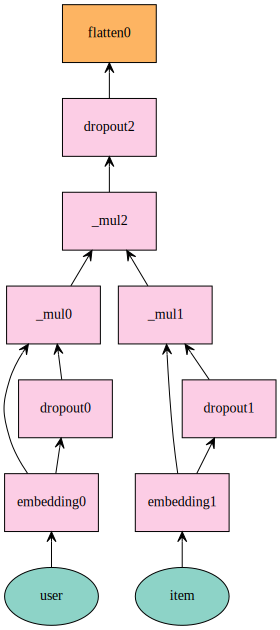

time: 147 ms


In [43]:
import mxnet as mx

user = mx.symbol.Variable('user')
item = mx.symbol.Variable('item')
score = mx.symbol.Variable('score')

# Set dummy dimensions
k = 64
max_user = 100
max_item = 50

# user feature lookup
user = mx.symbol.Embedding(data = user, input_dim = max_user, output_dim = k)
user_drop = mx.symbol.Dropout(data = user)
_user = user * user_drop
# item feature lookup
item = mx.symbol.Embedding(data = item, input_dim = max_item, output_dim = k)
item_drop = mx.symbol.Dropout(data = item)
_item = item * item_drop
# user = mx.symbol.Dropout()

# predict by the inner product, which is elementwise product and then sum
net = _user * _item 

# net = mx.symbol.sum_axis(data = net, axis = 1)

net = mx.symbol.Dropout(data = net)
net = mx.symbol.Flatten(data = net)

# loss layer
# net = mx.symbol.LinearRegressionOutput(data = net, label = score)

# Visualize your network
mx.viz.plot_network(net)



In [44]:
num_embeddings = 64

net = MFBlock(max_users=customer_index.shape[0], 
              max_items=product_index.shape[0],
              num_emb=num_embeddings,
              dropout_p=0.5)


time: 3.2 ms


In [45]:
type(net)

__main__.MFBlock

time: 2 ms


### Set Parameters

Let's initialize network weights and set our optimization parameters.

## Set optimization parameters

In [46]:
# Set optimization parameters
opt = 'sgd'
lr = 0.02
momentum = 0.9
wd = 0.

time: 942 µs


In [47]:
# Initialize network parameters
ctx = mx.gpu()
print("mx.gpu(): ", ctx)

net.collect_params().initialize(mx.init.Xavier(magnitude=60),
                                ctx=ctx,
                                force_reinit=True)
net.hybridize()

trainer = gluon.Trainer(net.collect_params(),
                        opt,
                        {'learning_rate': lr,
                         'wd': wd,
                         'momentum': momentum})

mx.gpu():  gpu(0)
time: 3.51 s


### Execute

Let's define a function to carry out the training of our neural network.

In [48]:
train_mse_list=[]

time: 644 µs


In [49]:
train_mse_list.append

<function list.append>

time: 2.12 ms


In [50]:
def execute(train_iter, test_iter, net, epochs, ctx):
    
    loss_function = gluon.loss.L2Loss()
    for e in range(epochs):

    
        print("epoch: {}".format(e))
        
        for i, (user, item, label) in enumerate(train_iter):
                user = user.as_in_context(ctx)
                item = item.as_in_context(ctx)
                label = label.as_in_context(ctx)
                
                with mx.autograd.record():
                    output = net(user, item)               
                    loss = loss_function(output, label)
                    
                loss.backward()
                trainer.step(batch_size)

        print("EPOCH {}: MSE ON TRAINING and TEST: {}. {}".format(e,
                                                                   eval_net(train_iter, net, ctx, loss_function),
                                                                   eval_net(test_iter, net, ctx, loss_function)))
        
       
    print("end of training")
    return net

time: 3.41 ms


#### Let's also define a function which evaluates our network on a given dataset.  This is called by our `execute` function above to provide mean squared error values on our training and test datasets.

# !!! Evaluation function

In [51]:
def eval_net(data, net, ctx, loss_function):
    acc = MSE()
    for i, (user, item, label) in enumerate(data):
        
            user = user.as_in_context(ctx)
            item = item.as_in_context(ctx)
            label = label.as_in_context(ctx)
            predictions = net(user, item).reshape((batch_size, 1))
            acc.update(preds=[predictions], labels=[label])
   
    return acc.get()[1]

time: 1.99 ms


Now, let's train for a few epochs.

In [52]:
%%time

epochs = 3

trained_net = execute(train_iter, test_iter, net, epochs, ctx)

epoch: 0
EPOCH 0: MSE ON TRAINING and TEST: 3.7679208517074585. 3.764685344696045
epoch: 1
EPOCH 1: MSE ON TRAINING and TEST: 2.0611860275268556. 2.0680049777030947
epoch: 2
EPOCH 2: MSE ON TRAINING and TEST: 2.356699275970459. 2.350901699066162
end of training
CPU times: user 622 ms, sys: 82.8 ms, total: 705 ms
Wall time: 642 ms
time: 644 ms


# train and prediction in Local

In [53]:
%%time

# Set optimization parameters
epochs = 100
opt = 'sgd'
lr = 0.02
momentum = 0.9
wd = 0.


trainer = gluon.Trainer(net.collect_params(),
                        opt,
                        {'learning_rate': lr,
                         'wd': wd,
                         'momentum': momentum})

trained_net = execute(train_iter, test_iter, net, epochs, ctx)

epoch: 0
EPOCH 0: MSE ON TRAINING and TEST: 1.7117404341697693. 1.702070713043213
epoch: 1
EPOCH 1: MSE ON TRAINING and TEST: 1.8563762426376342. 1.866938328742981
epoch: 2
EPOCH 2: MSE ON TRAINING and TEST: 1.5899645566940308. 1.5651812553405762
epoch: 3
EPOCH 3: MSE ON TRAINING and TEST: 1.5203769965605303. 1.528638330372897
epoch: 4
EPOCH 4: MSE ON TRAINING and TEST: 1.4039780259132386. 1.4096571803092957
epoch: 5
EPOCH 5: MSE ON TRAINING and TEST: 1.3118886709213258. 1.3076252818107605
epoch: 6
EPOCH 6: MSE ON TRAINING and TEST: 1.278482437133789. 1.2903834342956544
epoch: 7
EPOCH 7: MSE ON TRAINING and TEST: 1.2089710474014281. 1.2046672821044921
epoch: 8
EPOCH 8: MSE ON TRAINING and TEST: 1.0999534249305725. 1.1035776615142823
epoch: 9
EPOCH 9: MSE ON TRAINING and TEST: 1.0699813485145568. 1.06204993724823
epoch: 10
EPOCH 10: MSE ON TRAINING and TEST: 1.018407333980907. 1.0180831172249534
epoch: 11
EPOCH 11: MSE ON TRAINING and TEST: 0.9465285956859588. 0.9503132402896881
epoch: 

In [54]:
trained_net.summary

<bound method Block.summary of MFBlock(
  (user_embeddings): Embedding(10534 -> 64, float32)
  (item_embeddings): Embedding(10242 -> 64, float32)
  (dropout_user): Dropout(p = 0.5, axes=())
  (dropout_item): Dropout(p = 0.5, axes=())
  (dense_user): Dense(64 -> 64, Activation(relu))
  (dense_item): Dense(64 -> 64, Activation(relu))
)>

time: 2.35 ms


#### Early Validation

We can see our training error going down, but our validation accuracy bounces around a bit.  Let's check how our model is predicting for an individual user.  We could pick randomly, but for this case, let's try user #6.

In [55]:
product_index['u6_predictions'] = trained_net(nd.array([6] * product_index.shape[0]).as_in_context(ctx), 
                                              nd.array(product_index['item'].values).as_in_context(ctx)).asnumpy()
product_index.sort_values('u6_predictions', ascending=False)

,product_id,item,u6_predictions
5238,B0065SDTLS,5238,6.305015
7686,B00RXI5EY4,7686,6.248839
2850,B00IE18AM2,2850,6.182717
10201,B00AZORUCW,10201,6.160579
3540,B00200K8KK,3540,6.135994
6744,B006ZNCODC,6744,6.071641
3230,B00C3EMFS6,3230,6.067893
8221,B0073VBBIY,8221,6.033623
5910,B000YYLKHE,5910,6.017969
4324,B0008MFDEI,4324,6.017260


time: 65.7 ms


Now let's compare this to the predictions for another user (we'll try user #7).

In [56]:
product_index['u7_predictions'] = trained_net(nd.array([7] * product_index.shape[0]).as_in_context(ctx), 
                                              nd.array(product_index['item'].values).as_in_context(ctx)).asnumpy()
product_index.sort_values('u7_predictions', ascending=False)

,product_id,item,u6_predictions,u7_predictions
3355,B005DNAYDW,3355,5.870559,6.312834
2641,B00K01FKLI,2641,5.153759,6.154777
9118,B00FFC56CK,9118,5.600296,6.154257
3540,B00200K8KK,3540,6.135994,6.137447
3514,B005GXUSQ2,3514,5.214823,6.053624
7480,B00D037IRM,7480,5.948318,6.036866
5191,B00OFHM37W,5191,5.478827,6.017517
206,B0088X2IH4,206,5.498401,5.990711
5238,B0065SDTLS,5238,6.305015,5.989287
5882,B00NFV2U40,5882,5.770728,5.962039


time: 24.9 ms


The predicted ratings are different between the two users, but the same top (and bottom) items for user #6 appear for #7 as well.  Let's look at the correlation across the full set of 38K items to see if this relationship holds.

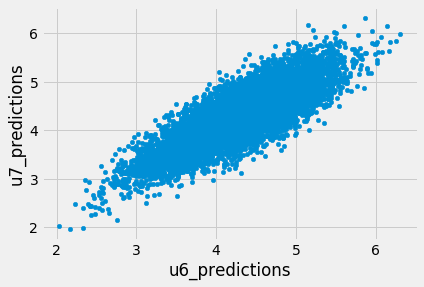

time: 352 ms


In [57]:
product_index[['u6_predictions', 'u7_predictions']].plot.scatter('u6_predictions', 'u7_predictions')
plt.show()

We can see that this correlation is nearly perfect.  Essentially the average rating of items dominates across users and we'll recommend the same well-reviewed items to everyone.  As it turns out, we can add more embeddings and this relationship will go away since we're better able to capture differential preferences across users.

However, with just a 64 dimensional embedding, it took 7 minutes to run just 3 epochs.  If we ran this outside of our Notebook Instance we could run larger jobs and move on to other work would improve productivity.



# Predict for all users in local

In [58]:
%%time

# Set optimization parameters
epochs = 500
opt = 'sgd'
lr = 0.02
momentum = 0.9
wd = 0.

trainer = gluon.Trainer(net.collect_params(),
                        opt,
                        {'learning_rate': lr,
                         'wd': wd,
                         'momentum': momentum})

trained_net = execute(train_iter, test_iter, net, epochs, ctx)

epoch: 0
EPOCH 0: MSE ON TRAINING and TEST: 0.24907028675079346. 0.2485296532511711
epoch: 1
EPOCH 1: MSE ON TRAINING and TEST: 0.24842677712440492. 0.24876000434160234
epoch: 2
EPOCH 2: MSE ON TRAINING and TEST: 0.23891172856092452. 0.2381374195218086
epoch: 3
EPOCH 3: MSE ON TRAINING and TEST: 0.23960698544979095. 0.24003330916166304
epoch: 4
EPOCH 4: MSE ON TRAINING and TEST: 0.23626965284347534. 0.23847542703151703
epoch: 5
EPOCH 5: MSE ON TRAINING and TEST: 0.22508383880962024. 0.224029465155168
epoch: 6
EPOCH 6: MSE ON TRAINING and TEST: 0.22322055995464324. 0.2231897696852684
epoch: 7
EPOCH 7: MSE ON TRAINING and TEST: 0.2350229561328888. 0.23562388718128205
epoch: 8
EPOCH 8: MSE ON TRAINING and TEST: 0.22506736083464188. 0.22534690499305726
epoch: 9
EPOCH 9: MSE ON TRAINING and TEST: 0.26205761134624483. 0.2622961729764938
epoch: 10
EPOCH 10: MSE ON TRAINING and TEST: 0.20537285953760148. 0.2040727972984314
epoch: 11
EPOCH 11: MSE ON TRAINING and TEST: 0.2570281535387039. 0.256

In [59]:
products.head()

B00CGK5GWE    33
B004Q7AB4I    26
B0015MN91O    17
B000PEINWS    16
B00LNCPM70    15
Name: product_id, dtype: int64

time: 3.69 ms


In [61]:
reduced_df.columns

Index(['customer_id', 'product_id', 'star_rating', 'product_parent',
       'product_category', 'product_title', 'helpful_votes', 'user', 'item'],
      dtype='object')

time: 3.35 ms


In [65]:
reduced_df.head(n=2)

,customer_id,product_id,star_rating,product_parent,product_category,product_title,helpful_votes,user,item
0,52181093,B008709MDG,5.0,694981365,Jewelry,.925 Sterling Silver 6mm Round Cubic Zirconia ...,2.0,2229,5676
1,52181093,B004Z1OSRQ,5,609609182,Jewelry,Sterling Silve Simulated Birthstone Round Crys...,11.0,2229,5531


time: 10.7 ms


In [ ]:
# customer_index_list=[1,2,3]
customer_index_list = customer_index['user'].tolist()

# # 0 to 1000 customer
# customer_index_list = [*range(0, 1000, 1)]


print("Total number of cutomers: ", len(customer_index_list))

product_index_local = pd.DataFrame({'product_id': products.index, 
                                    'product_url': 'https://www.amazon.com/dp/'+products.index, 
                              'item': np.arange(products.shape[0])})
all_predictions_from_user = pd.DataFrame(columns=['customer_id', 'product_id', 'product_url', 'prediction', 'product_title'])

for user_index in customer_index_list:
    print("test_customer_index:", user_index)
    
    product_index_local['prediction'] = trained_net(nd.array([7] * product_index_local.shape[0]).as_in_context(ctx), 
                                              nd.array(product_index_local['item'].values).as_in_context(ctx)).asnumpy()

    product_index_local['customer_id'] = customer_index[customer_index['user'] == user_index]['customer_id'].values.tolist()[0]
    
    # titles
    titles = reduced_df.groupby('product_id')['product_title'].last().reset_index()
    predictions_titles_local = product_index_local.merge(titles)
    
    # product_category
    product_category = reduced_df.groupby('product_id')['product_category'].last().reset_index()
    predictions_catalogs_local = predictions_titles_local.merge(product_category)
    
    # product_parent
    product_parent = reduced_df.groupby('product_id')['product_parent'].last().reset_index()
    predictions_catalogs_local = predictions_catalogs_local.merge(product_parent)
    
    predictions_titles_local = predictions_catalogs_local.sort_values(['prediction', 'product_id'], ascending=[False, True])
    
    
    #combine all results
    all_predictions_from_user = pd.concat([all_predictions_from_user, predictions_titles_local])
    all_predictions_from_user = pd.concat([all_predictions_from_user, predictions_catalogs_local])
    
    # select top 50 recommeded product
    predictions_titles_local = predictions_titles_local.head(n=50)
    
#reset index
all_predictions_from_user = all_predictions_from_user.reset_index(drop=True)
all_predictions_from_user = all_predictions_from_user[['customer_id', 'product_id', 'product_url', 'prediction',  'product_title', 'product_category', 'product_parent']]

# #generate csv file
all_predictions_from_user.to_csv("./Apparel_Jewelry_Shoes_predictions_from_user.csv")
# #generate pickle file
all_predictions_from_user.to_csv("./Apparel_Jewelry_Shoes_predictions_from_user.pickle")

all_predictions_from_user.head(n=10)


Total number of cutomers:  10534
test_customer_index: 0
test_customer_index: 1


/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:39: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:40: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




test_customer_index: 2
test_customer_index: 3
test_customer_index: 4
test_customer_index: 5
test_customer_index: 6
test_customer_index: 7
test_customer_index: 8
test_customer_index: 9
test_customer_index: 10
test_customer_index: 11
test_customer_index: 12
test_customer_index: 13
test_customer_index: 14
test_customer_index: 15
test_customer_index: 16
test_customer_index: 17
test_customer_index: 18
test_customer_index: 19
test_customer_index: 20
test_customer_index: 21
test_customer_index: 22
test_customer_index: 23
test_customer_index: 24
test_customer_index: 25
test_customer_index: 26
test_customer_index: 27
test_customer_index: 28
test_customer_index: 29
test_customer_index: 30
test_customer_index: 31
test_customer_index: 32
test_customer_index: 33
test_customer_index: 34
test_customer_index: 35
test_customer_index: 36
test_customer_index: 37
test_customer_index: 38
test_customer_index: 39
test_customer_index: 40
test_customer_index: 41
test_customer_index: 42
test_customer_index: 43


In [79]:
predictions_titles_local.columns

Index(['product_id', 'product_url', 'item', 'prediction', 'customer_id',
       'product_title', 'product_category', 'product_parent'],
      dtype='object')

time: 3.24 ms


In [ ]:
!ls -alrt Apparel_Jewelry_Shoes_predictions_from_user*

In [ ]:
!aws s3 cp Apparel_Jewelry_Shoes_predictions_from_user.csv s3://dse-cohort5-group1/1_Prediction_results/Apparel_Jewelry_Shoes/data/Apparel_Jewelry_Shoes_predictions_from_user.csv

In [ ]:
!aws s3 cp Apparel_Jewelry_Shoes_predictions_from_user.pickle s3://dse-cohort5-group1/1_Prediction_results/Apparel_Jewelry_Shoes/data/Apparel_Jewelry_Shoes_predictions_from_user.pickle

---

## Train with SageMaker

Now that we've trained on this smaller dataset, we can expand training in SageMaker's distributed, managed training environment.

### Wrap Code

To use SageMaker's pre-built MXNet container, we'll need to wrap our code from above into a Python script.  There's a great deal of flexibility in using SageMaker's pre-built containers, and detailed documentation can be found [here](https://github.com/aws/sagemaker-python-sdk#mxnet-sagemaker-estimators), but for our example, it consisted of:
1. Wrapping all data preparation into a `prepare_train_data` function (we could name this whatever we like)
1. Copying and pasting classes and functions from above word-for-word
1. Defining a `train` function that:
  1. Adds a bit of new code to pick up the input TSV dataset on the SageMaker Training cluster
  1. Takes in a dict of hyperparameters (which we specified as globals above)
  1. Creates the net and executes training
  
---

## !!! You have to apploy all above code change into recommender.py

- check recommender.py code before run

In [ ]:
# !cat recommender.py

### Test Locally

Now we can test our train function locally.  This helps ensure we don't have any bugs before submitting our code to SageMaker's pre-built MXNet container.

In [ ]:
!ls -al /tmp/recsys/

In [ ]:
%%time

import recommender

local_test_net, local_customer_index, local_product_index = recommender.train(
    {'train': '/tmp/recsys/'}, 
    {'num_embeddings': 64, 
     'opt': 'sgd', 
     'lr': 0.02, 
     'momentum': 0.9, 
     'wd': 0.,
     'epochs': 2},
    ['local'],
    1)

### Move Data

Holding our data in memory works fine when we're interactively exploring a sample of data, but for larger, longer running processes, we'd prefer to run them in the background with SageMaker Training.  To do this, let's move the dataset to S3 so that it can be picked up by SageMaker training.  This is perfect for use cases like periodic re-training, expanding to a larger dataset, or moving production workloads to larger hardware.

In [ ]:
# change log level
import logging

logger = logging.getLogger()
logger.addHandler(logging.StreamHandler()) # Writes to console
logger.setLevel(logging.DEBUG)
logging.getLogger('boto3').setLevel(logging.CRITICAL)
logging.getLogger('botocore').setLevel(logging.CRITICAL)
logging.getLogger('s3transfer').setLevel(logging.CRITICAL)
logging.getLogger('urllib3').setLevel(logging.CRITICAL)

In [ ]:
bucket

In [ ]:
prefix

In [ ]:
# amazon_reviews_us_Shoes_v1_00

boto3.client('s3').copy({'Bucket': 'amazon-reviews-pds', 
                         'Key': 'tsv/amazon_reviews_us_Shoes_v1_00.tsv.gz'},
                        bucket,
                        prefix + '/train/amazon_reviews_us_Shoes_v1_00.tsv.gz')

### Submit

Now, we can create an MXNet estimator from the SageMaker Python SDK.  To do so, we need to pass in:
1. Instance type and count for our SageMaker Training cluster.  SageMaker's MXNet containers support distributed GPU training, so we could easily set this to multiple ml.p2 or ml.p3 instances if we wanted.
  - *Note, this would require some changes to our recommender.py script as we would need to setup the context an key value store properly, as well as determining if and how to distribute the training data.*
1. An S3 path for out model artifacts and a role with access to S3 input and output paths.
1. Hyperparameters for our neural network.  Since with a 64 dimensional embedding, our recommendations reverted too closely to the mean, let's increase this by an order of magnitude when we train outside of our local instance.  We'll also increase the epochs to see how our accuracy evolves over time. We'll leave all other hyperparameters the same.

Once we use `.fit()` this creates a SageMaker Training Job that spins up instances, loads the appropriate packages and data, runs our `train` function from `recommender.py`, wraps up and saves model artifacts to S3, and finishes by tearing down the cluster.

In [ ]:
print( 's3://{}/{}/train/'.format(bucket, prefix))

In [ ]:
!aws s3 ls s3://dse-cohort5-group1/sagemaker/amazon_reviews_us_Shoes_v1_00/train/

## Use ml.p3.8xlarge for training
```
2020-05-16 06:28:03 Completed - Training job completed
Training seconds: 203
Billable seconds: 203
```

In [ ]:
# # Set optimization parameters
# opt = 'sgd'
# lr = 0.02
# momentum = 0.9
# wd = 0.

In [ ]:
m = MXNet('recommender.py', 
          py_version='py3',
          role=role, 
          train_instance_count=1, 
          train_instance_type="ml.p3.8xlarge",
          output_path='s3://{}/{}/output'.format(bucket, prefix),
          hyperparameters={'num_embeddings': 512, 
                           'opt': opt, 
                           'lr': lr, 
                           'momentum': momentum, 
                           'wd': wd,
                           'epochs': 50},
         framework_version='1.1')

m.fit({'train': 's3://{}/{}/train/'.format(bucket, prefix)})

In [ ]:
print(net.summary)

---

# 1. Hyperparameter Tune using Sagemaker Hyperparameter tune

### working log - JH
### [05/17/2020] need to apply my metric for this model to use Sagemaker hyperparameter. But I don't know how to apply cusome metric to Couldwatch
 

Similar to training a single MXNet job in SageMaker, we define our MXNet estimator passing in the MXNet script, IAM role, (per job) hardware configuration, and any hyperparameters we're not tuning.

In [ ]:
# estimator = MXNet('recommender.py', 
#                   py_version='py3',
#                   role=role, 
#                   train_instance_count=1, 
#                   train_instance_type="ml.p3.8xlarge",
#                   output_path='s3://{}/{}/output'.format(bucket, prefix),
#                   base_job_name='Amazon-recomender-hpo-mxnet',
#                   hyperparameters={'num_embeddings': 512, 
#                                    'opt': opt, 
#                                    'lr': lr, 
#                                    'momentum': momentum, 
#                                    'wd': wd,
#                                    'epochs': 50},
#                  framework_version='1.4.1')



Once we've defined our estimator we can specify the hyperparameters we'd like to tune and their possible values.  We have three different types of hyperparameters.
- Categorical parameters need to take one value from a discrete set.  We define this by passing the list of possible values to `CategoricalParameter(list)`
- Continuous parameters can take any real number value between the minimum and maximum value, defined by `ContinuousParameter(min, max)`
- Integer parameters can take any integer value between the minimum and maximum value, defined by `IntegerParameter(min, max)`

*Note, if possible, it's almost always best to specify a value as the least restrictive type.  For example, tuning `thresh` as a continuous value between 0.01 and 0.2 is likely to yield a better result than tuning as a categorical parameter with possible values of 0.01, 0.1, 0.15, or 0.2.*

In [ ]:
# hyperparameter_ranges = {'optimizer': CategoricalParameter(['sgd', 'Adam']),
#                          'learning_rate': ContinuousParameter(0.01, 0.2),
#                          'momentum': ContinuousParameter(0., 0.99),
#                          'wd': ContinuousParameter(0., 0.001),
#                          'num_epoch': IntegerParameter(10, 50)}

Next we'll specify the objective metric that we'd like to tune and its definition.  This includes the regular expression (Regex) needed to extract that metric from the CloudWatch logs of our training job.

In [ ]:
# objective_metric_name = 'MSE-ON-TEST'
# metric_definitions = [{'Name': 'MSE-ON-TEST',
#                        'Regex': 'MSE-ON-TEST=([0-9\\.]+)'}]


# # # THE SCORING METRIC TO MAXIMIZE
# # objective_metric_name = 'Validation-accuracy'
# # metric_definitions = [{'Name': 'Validation-accuracy',
# #                        'Regex': 'validation: accuracy=([0-9\\.]+)'}]


# # objective_metric_name = 'loss'
# # metric_definitions = [{'Name': 'loss',
# #                        'Regex': 'Loss = (.*?);'}]

Now we can create a `HyperparameterTuner` object and fit it by pointing to our data in S3.  This kicks our tuning job off in the background.

Notice, we specify a much smaller number of total jobs, and a smaller number of parallel jobs.  Since our model uses previous training job runs to predict where to test next, we get better results (although it takes longer) when setting this to a smaller value.

In [ ]:
# tuner = HyperparameterTuner(estimator,
#                             objective_metric_name,
#                             hyperparameter_ranges,
#                             metric_definitions,
#                             max_jobs=2,
#                             max_parallel_jobs=1)

And finally, we can start our tuning job by calling `.fit()` and passing in the S3 paths to our train and test datasets.

In [ ]:
# tuner.fit(train_iter={'train': 's3://{}/{}/train/'.format(bucket, prefix)})

Let's just run a quick check of the hyperparameter tuning jobs status to make sure it started successfully and is `InProgress`.

_You will be unable to successfully run the following cells until the tuning job completes.  This step may take up to 2 hours._

Once the tuning job finishes, we can bring in a table of metrics.

In [ ]:
# bayes_metrics = sagemaker.HyperparameterTuningJobAnalytics(tuner._current_job_name).dataframe()
# bayes_metrics.sort_values(['FinalObjectiveValue'], ascending=False)

Looking at our results, we can see that, with one fourth the total training jobs, SageMaker's Automatic Model Tuning has produced a model with better accuracy 74% than our random search.  In addition, there's no guarantee that the effectiveness of random search wouldn't change over subsequent runs.

Let's compare our hyperparameter's relationship to eachother and the objective metric.

In [ ]:
# pd.plotting.scatter_matrix(pd.concat([bayes_metrics[['FinalObjectiveValue',
#                                                      'learning_rate',
#                                                      'momentum',
#                                                      'wd']],
#                                       bayes_metrics['TrainingStartTime'].rank()],
#                            axis=1),
#                            figsize=(12, 12))
# plt.show()

As we can see, our accuracy is only about 53% on our validation dataset.  CIFAR-10 can be challenging, but we'd want our accuracy much better than just over half if users are depending on an accurate prediction.

---

# 2. Tune: Random

One method of hyperparameter tuning that performs surprisingly well for how simple it is, is randomly trying a variety of hyperparameter values within set ranges.  So, for this example, we've created a helper script `random_tuner.py` to help us do this.

We'll need to supply:

* A function that trains our MXNet model given a job name and list of hyperparameters.  Note, `wait` is set to false in our `fit()` call so that we can train multiple jobs at once.
* A dictionary of hyperparameters where the ones we want to tune are defined as one of three types (`ContinuousParameter`, `IntegerParameter`, or `CategoricalParameter`) and appropriate minimum and maximum ranges or a list of possible values are provided.

In [ ]:
# inputs = {'train': 's3://{}/{}/train/'.format(bucket, prefix)}

In [ ]:
# inputs

In [ ]:
# def fit_random(job_name, hyperparameters):
#     m = MXNet('recommender.py', 
#               py_version='py3',
#               sagemaker_session=sagemaker.Session(),
#               role=role, 
#               train_instance_count=1, 
#               train_instance_type="ml.p2.8xlarge",
#               framework_version='1.4.1',
#               base_job_name='Amazon-hpo-mxnet-0516',
#               hyperparameters=hyperparameters
#               )
    
#     inputs = {'train': 's3://{}/{}/train/'.format(bucket, prefix)}
#     print("input for hyperparameter tunning: ", inputs)
#     m.fit(inputs, wait=False, job_name=job_name)

In [ ]:
#     {'num_embeddings': [64, 128] 
#      'opt': ['sgd', 'adam'] 
#      'lr': 0.02, 
#      'momentum': 0.9, 
#      'wd': 0.,
#      'epochs': 10}

In [ ]:
# # for Test

# hyperparameters = {'batch_size': 1024,
#                    'epochs': 2,
#                    'learning_rate': rt.ContinuousParameter(0.001, 0.5),
#                    'momentum': rt.ContinuousParameter(0., 0.99),
#                    'wd': rt.ContinuousParameter(0., 0.001)}

In [ ]:
# hyperparameters = {'batch_size': rt.CategoricalParameter([1024]),
#                    'num_embeddings': rt.CategoricalParameter([64, 128]),
#                    'opt': rt.CategoricalParameter(['sgd', 'Adam']),
#                    'epochs': 50,
#                    'learning_rate': rt.ContinuousParameter(0.001, 0.5),
#                    'momentum': rt.ContinuousParameter(0., 0.99),
#                    'wd': rt.ContinuousParameter(0., 0.001)}

Next, we can kick off our random search.  We've defined the total number of training jobs to be 120.  This is a large amount and drives most of the cost of this notebook.  Also, we've specified up to 8 jobs to be run in parallel.  This exceeds the default concurrent instance limit for ml.p3.8xlarge instances.  If you're just testing this notebook out, decreasing both values will control costs and allow you to complete successfully without requiring a service limit increase.

_Note, this step may take up to 2 hours to complete.  Even if you loose connection with the notebook in the middle, as long as the notebook instance continues to run, `jobs` should still be successfully created for future use._

In [ ]:
# %%time
# '''
# Runs random search for hyperparameters.
# Takes in:
#     train_fn: A function that kicks off a training job based on two positional arguments-
#         job name and hyperparameter dictionary.  Note, wait must be set to False if using .fit()
#     hyperparameters: A dictonary of hyperparameters defined with hyperparameter classes.
#     base_name: Base name for training jobs.  Defaults to 'random-hp-<timestamp>'.
#     max_jobs: Total number of training jobs to run.
#     max_parallel_jobs: Most training jobs to run concurrently. This does not affect the quality
#         of search, just helps stay under account service limits.
# Returns a dictionary of max_jobs job names with associated hyperparameter values.
# '''
# jobs = rt.random_search(fit_random,
#                         hyperparameters,
#                         max_jobs=120,
#                         max_parallel_jobs=1)

Once our random search completes, we'll want to compare our training jobs (which may take a few extra minutes to finish) in order to understand how our objective metric (% accuracy on our validation dataset) varies by hyperparameter values.  In this case, our helper function includes two functions.

* `get_metrics()` scrapes the CloudWatch logs for our training jobs and uses a regex to return any reported values of our objective metric.
* `table_metrics()` joins on the hyperparameter values for each job, grabs the ending objective value, and converts the result to a Pandas DataFrame.

In [ ]:
# random_metrics = rt.table_metrics(jobs, rt.get_metrics(jobs, 'validation: accuracy=([0-9\\.]+)'))
# random_metrics.sort_values(['objective'], ascending=False)

As we can see, there's a huge variation in percent accuracy.  Had we initially (unknowingly) set our learning rate near 0.5, momentum at 0.15, and weight decay to 0.0004, we would have an accuracy just over 20% (this is particularly bad considering random guessing would produce 10% accuracy).

But, we also found many successful hyperparameter value combinations, and reached a peak validation accuracy of 73.7%.  Note, this peak job occurs relatively early in our search but, due to randomness, our next best objective value occurred 89 jobs later.  The actual peak could have occurred anywhere within the 120 jobs and will change across multiple runs.  We can see that with hyperparameter tuning our accuracy is well above the default value baseline of 53%.

To get a rough understanding of how the hyperparameter values relate to one another and the objective metric, let's quickly plot them.

In [ ]:
# pd.plotting.scatter_matrix(random_metrics[['objective',
#                                            'learning_rate',
#                                            'momentum',
#                                            'wd',
#                                            'job_number']],
#                            figsize=(12, 12))
# plt.show()

In [ ]:
m

---

# Deploying to Sagemaker Endpoint - Host

### Now that we've trained our model, deploying it to a real-time, production endpoint is easy.

In [ ]:
predictor = m.deploy(initial_instance_count=1, 
                     instance_type='ml.m4.xlarge')
predictor.serializer = None

Now that we have an endpoint, let's test it out.  We'll predict user #6's ratings for the top and bottom ASINs from our local model.

*This could be done by sending HTTP POST requests from a separate web service, but to keep things easy, we'll just use the `.predict()` method from the SageMaker Python SDK.*

In [ ]:
predictor.predict(json.dumps({'customer_id': customer_index[customer_index['user'] == 6]['customer_id'].values.tolist(), 
                              'product_id': ['B00HSJRT7I', 'B001FA1O1S']}))

*Note, some of our predictions are actually greater than 5, which is to be expected as we didn't do anything special to account for ratings being capped at that value.  Since we are only looking to ranking by predicted rating, this won't create problems for our specific use case.*

In [ ]:
json.dumps({'customer_id': customer_index[customer_index['user'] == 6]['customer_id'].values.tolist(), 'product_id': ['B00HSJRT7I', 'B001FA1O1S']})

In [ ]:
reduced_df.sample(n=2)

## - Checking the Endpoint Status

In [ ]:
# !aws sagemaker describe-endpoint --endpoint-name  sagemaker-mxnet-2020-05-18-03-55-49-266

In [ ]:
type(predictor)

### Evaluate

Let's start by calculating a naive baseline to approximate how well our model is doing.  The simplest estimate would be to assume every user item rating is just the average rating over all ratings.

*Note, we could do better by using each individual product's average, however, in this case it doesn't really matter as the same conclusions would hold.*

In [ ]:
print('Naive MSE:', np.mean((test_df['star_rating'] - np.mean(train_df['star_rating'])) ** 2))

Now, we'll calculate predictions for our test dataset.

*Note, this will align closely to our CloudWatch output above, but may differ slightly due to skipping partial mini-batches in our eval_net function.*

In [ ]:
test_preds = []
for array in np.array_split(test_df[['customer_id', 'product_id']].values, 40):
    test_preds += predictor.predict(json.dumps({'customer_id': array[:, 0].tolist(), 
                                                'product_id': array[:, 1].tolist()}))

test_preds = np.array(test_preds)
print('MSE:', np.mean((test_df['star_rating'] - test_preds) ** 2))

We can see that our neural network and embedding model produces substantially better results (~1.27 vs 1.65 on mean square error).

For recommender systems, subjective accuracy also matters.  Let's get some recommendations for a random user to see if they make intuitive sense.

In [ ]:
reduced_df[reduced_df['user'] == 6].sort_values(['star_rating', 'item'], ascending=[False, True])

In [ ]:
reduced_df.to_csv("./amazon_reviews_us_Shoes_v1_00.csv")

As we can see, user #6 seems to like sprawling dramamtic television series and sci-fi, but they dislike silly comedies.

Now we'll loop through and predict user #6's ratings for every common product in the catalog, to see which ones we'd recommend and which ones we wouldn't.

In [ ]:
predictions = []
for array in np.array_split(product_index['product_id'].values, 40):
    predictions += predictor.predict(json.dumps({'customer_id': customer_index[customer_index['user'] == 6]['customer_id'].values.tolist() * array.shape[0], 
                                                 'product_id': array.tolist()}))

predictions = pd.DataFrame({'product_id': product_index['product_id'],
                            'prediction': predictions})

In [ ]:
predictions_user6 = []
for array in np.array_split(product_index['product_id'].values, 40):
    predictions_user6 += predictor.predict(json.dumps({'customer_id': customer_index[customer_index['user'] == 6]['customer_id'].values.tolist() * array.shape[0], 
                                                       'product_id': array.tolist()}))
plt.scatter(predictions['prediction'], np.array(predictions_user6))
plt.show()

In [ ]:
titles = reduced_df.groupby('product_id')['product_title'].last().reset_index()
predictions_titles = predictions.merge(titles)
predictions_titles = predictions_titles.sort_values(['prediction', 'product_id'], ascending=[False, True])
# pickup top 100 recommeded products only
predictions_titles = predictions_titles.head(n=100)
predictions_titles.head(n=10)

Indeed, our predicted highly rated shows have some well-reviewed TV dramas and some sci-fi.  Meanwhile, our bottom rated shows include goofball comedies.

*Note, because of random initialization in the weights, results on subsequent runs may differ slightly.*

Let's confirm that we no longer have almost perfect correlation in recommendations with user #7.

In [ ]:
predictions_titles.to_csv("./user_6_amazon_reviews_us_Shoes_v1_00.csv")

# Predict for all users

In [ ]:
# find user_id from user index

user_index = 3

customer_index[customer_index['user'] == user_index]['customer_id'].values.tolist()

In [ ]:
customer_index_list = customer_index['user'].tolist()

print("Total number of cutomers: ", len(customer_index_list))

# test
# customer_index_list=[1,2,3]

all_predictions_from_user = pd.DataFrame(columns=['customer_id', 'product_id', 'prediction', 'product_title'])

for user_index in customer_index_list:
    print("test_customer_index:", user_index)
    
    predictions = []
    for array in np.array_split(product_index['product_id'].values, 40):
        predictions += predictor.predict(json.dumps({'customer_id': customer_index[customer_index['user'] == user_index]['customer_id'].values.tolist() * array.shape[0], 
                                                     'product_id': array.tolist()}))

    
    customer_id = customer_index[customer_index['user'] == user_index]['customer_id'].values.tolist()
    print("customer_id: ",customer_id[0])
         
    predictions = pd.DataFrame({
                                'product_id': product_index['product_id'],
                                'prediction': predictions})
    predictions['customer_id'] = customer_id[0]
    predictions  = predictions[['customer_id', 'product_id', 'prediction']]
#     print(predictions.head(n=2))
    
    titles = reduced_df.groupby('product_id')['product_title'].last().reset_index()
    predictions_titles = predictions.merge(titles)
    predictions_titles = predictions_titles.sort_values(['prediction', 'product_id'], ascending=[False, True])
    # pickup top 100 recommeded products only
    predictions_titles = predictions_titles.head(n=100)
    
    print(predictions_titles.head(n=1))
    #combine all results
    all_predictions_from_user = pd.concat([all_predictions_from_user, predictions_titles])

#reset index
all_predictions_from_user = all_predictions_from_user.reset_index(drop=True)

#generate csv file
all_predictions_from_user.to_csv("Shoes_all_predictions_from_user.csv")

#generate pickle file
all_predictions_from_user.to_csv("Shoes_all_predictions_from_user.pickle")

all_predictions_from_user.head(n=10)

---

## Wrap-up

In this example, we developed a deep learning model to predict customer ratings.  This could serve as the foundation of a recommender system in a variety of use cases.  However, there are many ways in which it could be improved.  For example we did very little with:
- hyperparameter tuning
- controlling for overfitting (early stopping, dropout, etc.)
- testing whether binarizing our target variable would improve results
- including other information sources (historical ratings, time of review)
- adjusting our threshold for user and item inclusion 

In addition to improving the model, we could improve the engineering by:
- Setting the context and key value store up for distributed training
- Fine tuning our data ingestion (e.g. num_workers on our data iterators) to ensure we're fully utilizing our GPU
- Thinking about how pre-processing would need to change as datasets scale beyond a single machine

Beyond that, recommenders are a very active area of research and techniques from active learning, reinforcement learning, segmentation, ensembling, and more should be investigated to deliver well-rounded recommendations.

### Clean-up (optional)

Let's finish by deleting our endpoint to avoid stray hosting charges.

In [ ]:
sagemaker.Session().delete_endpoint(predictor.endpoint)

## Reference APID

- MXNet Estimator
    - https://sagemaker.readthedocs.io/en/stable/sagemaker.mxnet.html#mxnet-estimator
    